<a href="https://colab.research.google.com/github/ldmcgo26/DL_Assignment_5/blob/main/Liam_McGoldrick_08_AIT_CNN_CIFAR10_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Convolutional Neural Network exercise

In this notebook, you will build a convolutional neural network, which offers superior results over the previous MLP solution. Additionally, you will perform a more detailed evaluation.

In [17]:
# imports
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. Data
The dataset we will use is the well-known CIFAR10 (Canadian Institute For Advanced Research). Explore the details on the Keras website first: https://keras.io/api/datasets/cifar10/

There isn't much difference between the data preprocessing part and the one we did before. The only difference is that we don't have to reshape images into vectors, but we are working with a 4 dimensional data structure, where the dimensions are: batch, X, Y, and color channels.

In the event that anything is not clear regarding the data preparation part, please check the previous CIFAR10 notebook.

In [18]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [4]:
# it is in int8 format, the neural network requires float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [19]:
train_ratio  = 0.8
train_length = X_train.shape[0]
train_split  = int(train_ratio*train_length)
X_valid, Y_valid = X_train[train_split:], Y_train[train_split:]
X_train, Y_train = X_train[:train_split], Y_train[:train_split]

In [20]:
mean = X_train.mean(axis=0)
std  = X_train.std(axis=0)

X_train = (X_train-mean)/std
X_valid = (X_valid-mean)/std
X_test  = (X_test-mean)/std

In [21]:
nb_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, nb_classes)
Y_valid = to_categorical(Y_valid, nb_classes)
Y_test  = to_categorical(Y_test, nb_classes)

In [22]:
print("Shapes of the training, validation and test input data:", X_train.shape, X_valid.shape, X_test.shape)
print("Shapes of the training, validation and test output data:", Y_train.shape, Y_valid.shape, Y_test.shape)
print("Mean values of the training, validation and test input data:", X_train.mean(), X_valid.mean(), X_test.mean())
print("Standard deviation of the training, validation and test input data:", X_train.std(), X_valid.std(), X_test.std())

Shapes of the training, validation and test input data: (40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
Shapes of the training, validation and test output data: (40000, 10) (10000, 10) (10000, 10)
Mean values of the training, validation and test input data: -3.904284303265134e-18 0.0023437140466796725 0.013331171092908297
Standard deviation of the training, validation and test input data: 1.0000000000000009 0.9965601589924467 0.9978282721027754


# 2. Exercise: training

Create and train a convolutional neural network with the following requirements:
* apply early stopping with patience=5 and monitor the validation accuracy, don't forget to load back the best weights after early stopping
* the number of trainable parameters is lower than 200.000
* the validation accuracy must be higher than 72%

Hints:
* you can always inspect the number of trainable parameters per layer with model.summary()
* usually the most trainable parameters are between the last convolutional layer and the next dense layer -- so you should have a reasonable output size at the last convolutional layer
* regularization helps (e.g. DropOut and/or BatchNormalization)
* use the right activation function at the output layer and the corresponding loss function
* for the chosen activation functions, please use the appropriate initialization method
* you can match the dimension of the last conv/pooling layer to the next dense layer with e.g. Flatten()
* ADAM optimizer is a reasonable choice
* don't forget to turn on GPU support in Colab, otherwise, it would be quite slow to train the networks



In [23]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True) # early stopping

In [24]:
# model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# loss function and optimizer
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,098 (629.29 KB)

 Trainable params: 160,650 (627.54 KB)

 Non-trainable params: 448 (1.75 KB)

Please, check the number of trainable paramers:

In [26]:
print("#trainable parameters:",model.count_params())

#trainable parameters: 161098


In [27]:
# training
network_history = model.fit(X_train, Y_train,
                            validation_data=(X_valid,Y_valid),
                            batch_size=128,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.2414 - loss: 2.3534 - val_accuracy: 0.4018 - val_loss: 1.7371
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3928 - loss: 1.6509 - val_accuracy: 0.4366 - val_loss: 1.7756
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4578 - loss: 1.4973 - val_accuracy: 0.4829 - val_loss: 1.5941
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4958 - loss: 1.3886 - val_accuracy: 0.5467 - val_loss: 1.2969
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5305 - loss: 1.3074 - val_accuracy: 0.5625 - val_loss: 1.2754
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5541 - loss: 1.2480 - val_accuracy: 0.5902 - val_loss: 1.1820
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5803 - loss: 1.1839 - val_accuracy: 0.6095 - val_loss: 1.1103
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6082 - loss: 1.1091 - val_a

# 3. Exercise: evaluation on test data
You will evaluate the classification of the test data using the common metrics and the confusion matrix in this section.


As a first stes, let's run the predictions and convert the predicted softmax outputs to dense labels. The one-hot encoded labels are also converted back to dense labels, as they are required for the evaluation functions.

In [28]:
probas = model.predict(X_test)
preds  = np.argmax(probas,axis=1)
Y_test_dense = np.argmax(Y_test, axis=1) # get the original dense labels of the test data

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


## 3.1. Exercise: Metrics
please review the common classification metrics (accuracy, precision, recall, F1) for the complete model (not per class).

Hints:
* use macro averaging
* you have to import the right functions from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [31]:
print("Accuracy:", accuracy_score(Y_test_dense, preds))
print("Precision:", precision_score(Y_test_dense, preds, average='macro'))
print("Recall:", recall_score(Y_test_dense, preds, average='macro'))
print("F1:", f1_score(Y_test_dense, preds, average='macro'))

Accuracy: 0.7891
Precision: 0.7908655854555456
Recall: 0.7891
F1: 0.7881296690194352



## 3.2. Exercise: Confusion matrix
Calculate the confusion matrix and display the results in a heatmap (with decimal values).

Hints:
* you have to do the imports this time too, e.g. from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and the [heatmap function](https://seaborn.pydata.org/generated/seaborn.heatmap.html) of [seaborn](https://seaborn.pydata.org/)
* for displaying the decimal values, you have to turn annot=True and define fmt='d' in the heatmap function of seaborn

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

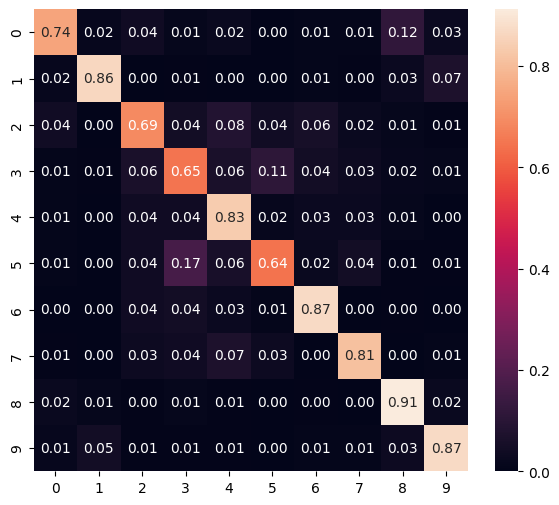

In [41]:
conf = confusion_matrix(Y_test_dense, preds, normalize='true')
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='.2f')
plt.show()